# Time Series Prediction

<br>

- TF, keras를 써서 시계열 예측을 한번 해보자.
- CNN, RNN을 써서 몇가지 다른 스타일의 모델을 빌드.

각각 하위 항목이 있는 두 부분으로 나눠서 진행해보자.
- 단일 timestamp 예측:
    - 단일 특성
    - 모든 특성
- 다중 timestamp 예측:
    - singeshot : 모두 한번에 예측
    - Autoregressive : 한번에 하나의 예측을 수행, 결과를 모델에 피드백.

## 준비

In [16]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

## Weather Dataset

<br>

- 막스 플랑크 생물 지구화학 연구소 에서 기록한 날씨  시계열 데이터 셋 사용.
- 온도, 대기압 및 습도와 같은 14가지 특성이 존재.
- 2003년부터 시작해 10분 간격으로 수집.
    - 2012년과 2018년 사이에 수집된 데이터만 사용하자.
    - 파일 없다함. 2009~2016 으로 하자.

In [17]:
zip_path = keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

**시간별 예측**만을 수행하므로, 10분 간격부터 1시간까지 데이터를 서브 샘플링 하자.

In [18]:
df = pd.read_csv(csv_path) # 'C:\\Users\\skdbs\\.keras\\datasets\\jena_climate_2009_2016.csv'

# slicing. 5번째 인덱스부터 6번째 마다 있는걸 가져옴. (10분 주기로 저장이니까 6칸씩이면 1시간.)
df = df[5::6]

# Datetime은 따로 빼자.
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# head를 한번 봐보자.
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


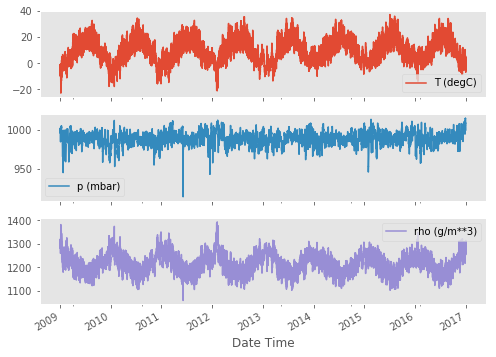

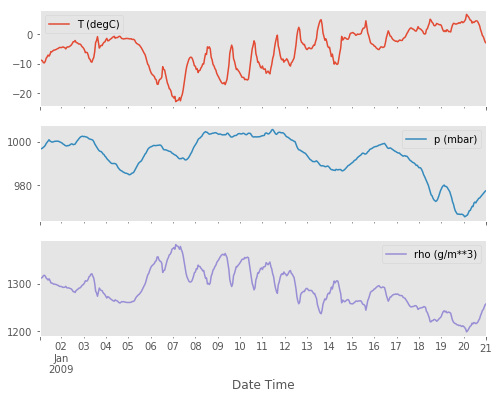

In [19]:
# 몇가지 특성들만 골라서 한번 봐보자.
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

    딱 봐도 뭔가 주기성을 가지고 있는것 같다.

## 데이터 검사 및 간단한 전처리

<br>

먼저 통계량을 한번 살펴보자.

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


    잘 보면 wv (m/s) [풍속]의 min, max. wv (m/x) [최대풍속]의 min값이 -9999로 되어있음.
    별도의 풍향 col이 있으므로 속도는 0보다 커야 함. 0으로 대체하자.

In [21]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

In [22]:
# 다시 확인해보자.
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


    -9999.0 이 멀쩡히 0으로 바뀌었다.

## Feature Engineering

<br>

모델을 본격적으로 만들기 전, **데이터를 이해**하고 **적절한 형식의 데이터를 전달하는 것**이 매~우 중요.

### 바람

- 데이터의 마지막 열인 wd (deg) 는 degree 단위로 바람의 방향을 나타내는 열.
- 각도가 있으면 모델의 입력이 조~금 좋지 않을 수있음.
- 360도와 0도는 서로 가까워야 되고 부드럽게 휘어져야 함.
- 먼저 바람 데이터의 분포를 한번 살펴보자.

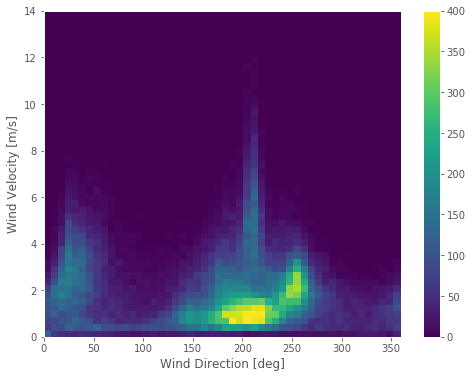

In [23]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

    풍향과 속도 col을 바람 vector로 변환하면 모델 해석이 쉬워질 것.
    (그림 해석을 어케해야될지 모르겠네....)

In [24]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 라디안으로 변환
wv_rad = df.pop('wd (deg)')*np.pi / 180

# 풍속, 최대풍속 각각 계산 후 추가
df['Wx'] = wv*np.cos(wv_rad)
df['Wy'] = wv*np.sin(wv_rad)
df['max Wx'] = max_wv*np.cos(wv_rad)
df['max Wy'] = max_wv*np.sin(wv_rad)

    바람 벡터의 분포는 모델을 올바르게 해석하기에 훨씬 더 간단.

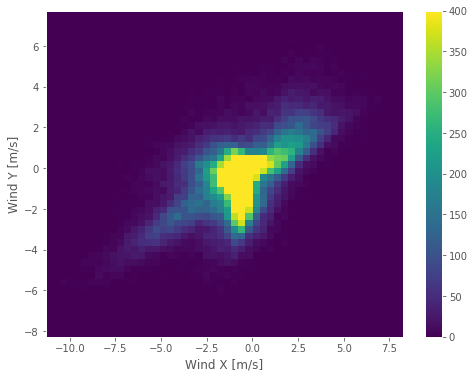

In [26]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

### 시간

<br>

- 마찬가지로 Date Time col은 매우 유용하지만, 문자열 형식으로는 사용할 수가 없음.
- 우선 초 단위로 변환하자.

In [27]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
timestamp_s

5         1.230739e+09
11        1.230743e+09
17        1.230746e+09
23        1.230750e+09
29        1.230754e+09
              ...     
420521    1.483179e+09
420527    1.483183e+09
420533    1.483186e+09
420539    1.483190e+09
420545    1.483193e+09
Name: Date Time, Length: 70091, dtype: float64

- 풍향처럼 초 단위의 시간은 좋은 입력이 아님.
- 현재 데이터는 날씨 데이터. **하루 및 연 단위의 주기성**이 명확한 편.
- 주기성을 처리하는 방법엔 여러가지가 있음.
    - 그 중 사용가능한 신호로 변환하는 간단한 방법은 **sin**, **cos**를 이용하는 것.
    - 시간을 **명확한 '하루 중 시간' 및 '연중 시간' 신호로 변환**하는 것이다.
   
    (어우...좀 빡세다)

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


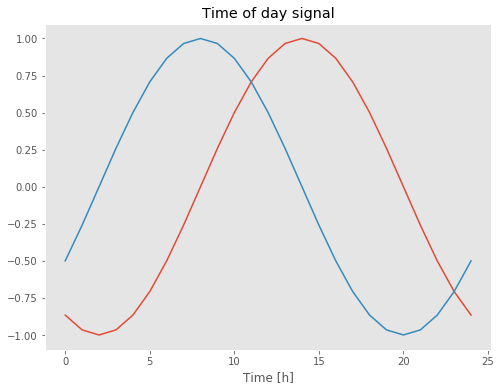

In [28]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

- fft를 사용해 중요한 빈도를 결정할 수 있다.
- 시간에 따른 온도의 tf.signal.rfft를 보면 가정한 내용을 확인할 수 있음.
    - 1/year 및 1/day 근처에서 빈도 피크가 확실하다는 것을 확인할 수 있다.

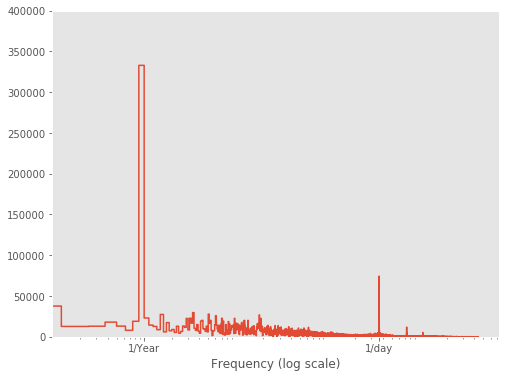

In [29]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.show()

## Data Splitting

<br>

- 훈련, 검증, 테스트 셋을 7:2:1 비율로 분할하자.
- 분할하기 전 데이터가 임의로 셔플되지 않음. 두가지 이유 때문.
    1. 데이터를 연속된 샘플 window로 자르는 것이 여전히 가능.  ($\leftarrow$ 이게 뭔소릴까...)
    2. 모델 훈련 후, 수집된 데이터를 바탕으로 평가함. 검증/테스트 결과가 보다 현실적이게 됨.

In [31]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0 : int(n*0.7)]
val_df = df[int(n*0.7) : int(n*0.9)]
test_df = df[int(n*0.9) : ]

num_features = df.shape[1]

## Data Normalizing

<br>

- 훈련을 시작하기 전 **특성들의 크기를 조절**하는 것이 중요.
    - **평균을 빼고 각 특성의 표준편차로 데이터들을 나눈다.**
- 모델이 **검증 및 테스트 셋의 값에 접근할 수 없도록**, **훈련 데이터만 사용해서 평균 및 표준편차를 계산**해야 한다.
    - 시계열 데이터라서 이러는듯?
- 모델이 훈련할 때, **훈련 셋이 미래 값에 접근할 수 없어야 하고**, 이 **정규화가 이동평균을 사용해 수행되어야 함.**
    - 이것도 마찬가지로 시계열 데이터라서.
- 그치만 이 예시에선 단순화를 위해 **단순 평균**을 사용합니다.

In [32]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

- 특성의 분포를 한번 살펴보자.

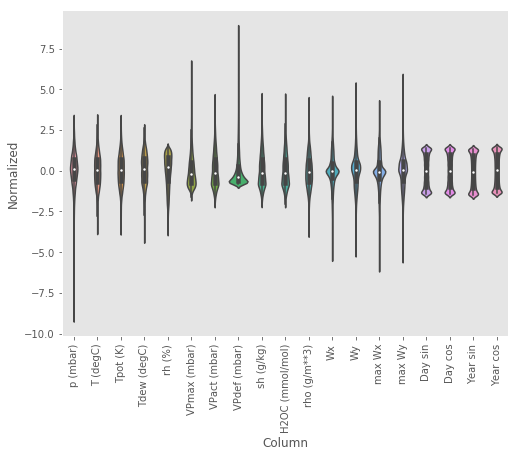

In [34]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
plt.show()

    일부 특성은 꼬리가 길지만, -9999 같은 오류는 없는 것으로 보임.

## Data Windowing

<br>

- 이 예시의 모델은 데이터의 연속된 샘플 윈도우를 기반으로 일련의 예측을 수행함.
- 입력 윈도우의 주요 특성은,
    - 입력 및 라벨 윈도우의 너비 (timestamp 수)
    - 입력 및 라벨 사이의 시간 오프셋
    - 입력 또는 라벨, 또는 둘 모두로 사용되는 특성
- 이 예시는 선형, DNN, CNN 및 RNN을 포함한 다양한 모델을 빌드하고, 다음 두가지 목적으로 모델을 사용함.
    1. 단일 출력 및 다중 출력 예측
    2. 단일 timestamp 및 다중 timestamp 예측
- 여기선 모든 모델에서 사용할 수 있도록 하는 데이터 윈도우 작업을 구현하는 데 중점을 둡니다.

    Window 개념이 뭔지 좀 찾아봐야 할 것 같다.

- 작업 및 모델 유형에따라 다양한 데이터 window를 생성할 수 있음. 
    1. 24시간의 기록이 주어졌을 때, 앞으로 24시간의 미래를 단일 예측하려면 다음과 같은 창을 정의할 수 있음.
    ![nn](UseData/raw_window_24h.png)
    2. 6시간의 기록이 주어졌을 때, 앞으로 1시간의 미래를 예측하려면 다음과 같은 창이 필요.
    ![nn](UseData/raw_window_1h.png)

- WindowGenerator 클래스를 정의. 이 클래스는 다음을 수행할 수 있음.
    1. 위 그림과 같이 인덱스와 오프셋을 처리.
    2. 특성 window를 (features, labels) 쌍으로 분할
    3. 결과 창의 내용을 plot
    4. tf.data.Dataset을 사용해 훈련, 검증 및 테스트 데이터로부터 이러한 창을 여러 배치로 효율적으로 생성.

### 인덱스 및 오프셋 처리

<br>

WindowGenerator 클래스 생성. _ _ init _ _ 메서드는 입력 및 라벨 인덱스에 필요한 모든 논리가 포함.  <br>
훈련, 검증 및 테스트 데이터 프레임을 입력으로 사용.  <br>
이런 데이터 프레임은 나중에 window의 tf.data.Datasets로 변환됨. ??

In [47]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # raw 데이터 저장
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # 라벨 열 인덱스 계산
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Window 파라미터 계산
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'총 윈도우 크기는 : {self.total_window_size}',
            f'입력 인덱스는 : {self.input_indices}',
            f'라벨 인덱스는 : {self.label_indices}',
            f'라벨의 컬럼 이름은 : {self.label_columns}'
        ])

    위 그림에서 설명했던 것을 실제 WindowGenerator를 통해 만들어보자.

In [48]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

총 윈도우 크기는 : 48
입력 인덱스는 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
라벨 인덱스는 : [47]
라벨의 컬럼 이름은 : ['T (degC)']

In [49]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])
w2

총 윈도우 크기는 : 7
입력 인덱스는 : [0 1 2 3 4 5]
라벨 인덱스는 : [6]
라벨의 컬럼 이름은 : ['T (degC)']

### Window를 (features, labels) 쌍으로 분할

<br>

- 연속적인 입력 목록이 주어지면 split_window 메서드는 이 목록을 입력 윈도우와 레이블 윈도우로 변환함.
- 위의 예제에서 w2는 다음과 같이 분할됨.

![nn](UseData/split_window.png)

- 이 다이어그램에선 데이터의 features축이 나와 있지 않음.
- 하지만 split_window 함수는 단일 출력과 다충 출력 예시에서 모두 사용될 수 있도록 label_columns를 처리함.

In [50]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
        # 이게 뭐지...
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],
                           axis=-1)

    # Slicing은 정적 모양 정보를 유지하지 않음. 모양을 직접 설정해줘야함.
    # 이렇게 하면 tf.data.Datasets를 더 쉽게 검사할 수 있음.
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [51]:
# 총 윈도우의 길이인 3개의 슬라이스를 쌓는다.
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('모든 형태는 (batch, time, features)와 같음.')
print(f'윈도우 형태는 : {example_window.shape}')
print(f'입력 형태는 : {example_inputs.shape}')
print(f'라벨 형태는 : {example_labels.shape}')

모든 형태는 (batch, time, features)와 같음.
윈도우 형태는 : (3, 7, 19)
입력 형태는 : (3, 6, 19)
라벨 형태는 : (3, 1, 1)


일반적으로 TF의 데이터는 가장 바깥 쪽 인덱스가 여러 예제('배치 차원)에 걸쳐있는 배열로 구성됨.  <br>
중간 인덱스는 '시간' 또는 '공간'(너비, 높이) 차원.  <br>
가장 안쪽 인덱스는 특성.

<br>

위 코드는 두 배치의 7-timestep window를 사용해 각 timestep에는 19개의 특성이 들어있음.  <br>
이것을 한 배치의 6-timestep와 19개의 특성입력 및 1-timestep 1-특성 라벨 로 분할.

<br>

라벨에는 하나의 특성만이 있는데, WindowGenerattor가 label_columns를 'T (degC)'로 초기화 했기 때문.

### 결과창 내용 Plot

<br>

- 분할 창을 간단하게 시각화 할 수 있는 메서드 정의.

In [52]:
w2.example = example_inputs, example_labels

In [57]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], 
                        marker='X', edgecolors='k', label='Predictions', 
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

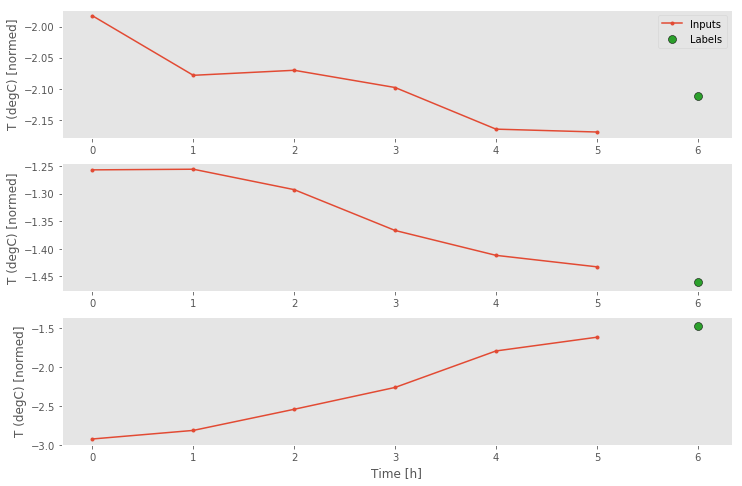

In [58]:
w2.plot()

    5시간 까지만 추세를 확인하고, 6시간 째의 부분이 목표값.

    참조하는 시간을 기준으로 입력, 라벨 및 예측값을 정렬해 표시.
    다른 열을 plot해 보고 싶다면 plot_col을 지정해주면 됨.

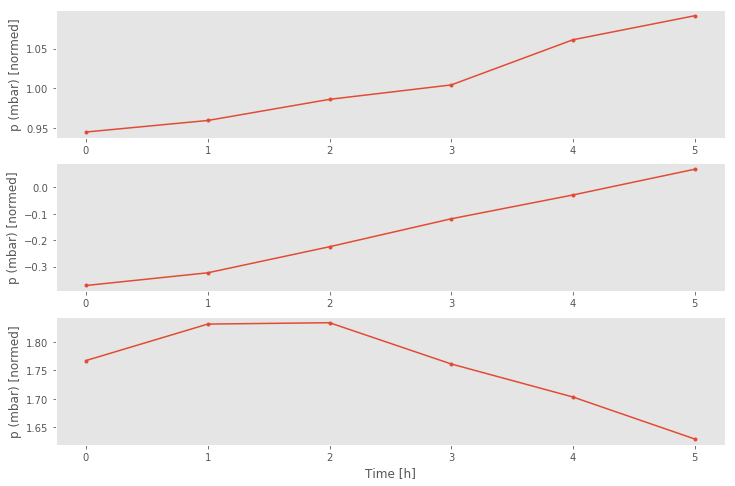

In [56]:
w2.plot(plot_col='p (mbar)')

### tf.data.Dataset 만들기

<br>

마지막으로 정의하는 make_dataset 메서드는 시계열 DataFrame을 가져와  <br>
keras.preprocessing.timeseries_dataset_from_array 함수를 이용해  <br>
(input_window, label_window) 쌍의 tf.data.Dataset으로 변환함.

In [65]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    dataset = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        shuffle=True,
        batch_size=32
    )
    dataset = dataset.map(self.split_window)
    return dataset

WindowGenerator.make_dataset = make_dataset

WindowGenerator 객체는 훈련, 검증 및 테스트 데이터를 보유하고 있음.  <br>
앞서 정의한 make_dataset을 사용해 tf.data.Datasets로 여기에 엑세스 하기 위한 특성을 추가하자.  <br>
그리고, 간편한 엑세스와 플롯을 위한 표준 예제 배치를 추가하자.

In [66]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    # 플롯팅을 위한 'inputs, labels'의 예제 배치를 가져온다.
    result = getattr(self, '_example', None)
    
    if result is None:
        # 적절한 예시 배치가 없으므로, '.train' 데이터셋에서 하나 가져온다.
        result = next(iter(self.train))
        # 그리고ㅓ 다음을 위해 캐싱한다.
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 WindowGenerator 객체가 tf.data.Dataset 객체에 대한 액세스 권한을 부여함. 데이터를 쉽게 재사용할 수 있음.

    Dataset.element_spec 은 데이터 셋 요소의 구조, dtypes 및 형태를 알려줌.

In [67]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

    이제 이 Dataset을 반복하면 견고한 배치가 완성된다.

In [68]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'입력 형태는 (batch, time, features) : {example_inputs.shape}')
    print(f'라벨 형태는 (batch, time, features) : {example_labels.shape}')

입력 형태는 (batch, time, features) : (32, 6, 19)
라벨 형태는 (batch, time, features) : (32, 1, 1)


## Single Step Model

<br>

- 이렇게 만든 데이터를 기반으로 빌드할 수 있는 가장 간단한 모델이 뭘까?
    - 현재 조건에만 기초해서, 미래로 1 timestep (1시간) 진행된 단일 특성값을 예측하는 모델.
- 따라서, 1시간 미래의 T (degC) 값을 예측하는 모델을 빌드하는 것부터 시작해보자.

![nn](UseData/narrow_window.png)

위처럼 단일 스텝 (input, label) 쌍을 생성하도록 WindowGenerator 객체를 생성.

In [69]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['T (degC)']
)
single_step_window

총 윈도우 크기는 : 2
입력 인덱스는 : [0]
라벨 인덱스는 : [1]
라벨의 컬럼 이름은 : ['T (degC)']

window 객체는 훈련, 검증 및 테스트 셋으로부터 tf.data.Datasets를 생성하므로 데이터 배치를 쉽게 반복할 수 있음.

In [70]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'입력 형태는 (batch, time, features) : {example_inputs.shape}')
    print(f'라벨 형태는 (batch, time, features) : {example_labels.shape}')

입력 형태는 (batch, time, features) : (32, 1, 19)
라벨 형태는 (batch, time, features) : (32, 1, 1)


### Baseline

<br>

- 훈련 가능한 모델을 빌드하기 전, 나중에 더 복잡한 모델과 비교하기 위한 포인트로 성능 기준(baseline)을 갖는 것이 좋다.
- 첫번째로 할 작업은, 모든 특성의 현재 값을 고려하면서 1시간 미래의 온도를 예측하는 것. 현재 값에는 현재 온도가 포함.
- 그러므로, 예측으로 현재 온도를 return해 '변화없음'을 예측하는 모델 부터 시작하자.
    - 온도는 급격하게 변하지 않고 천천히 변하기 때문에 합리적인 기준이 될 수 있다.
    - 물론, 더 미래로 간다면 이 기준의 예측 효과는 떨어질 수 있음.


![nn](UseData/baseline.png)

In [71]:
class Baseline(keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

    인스턴스화 하고 평가해보자.

In [73]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss='mse', metrics=['mae'])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mae: 0.0785


- 성능 메트릭을 출력했지만, **모델이 얼마나 잘 작동하는지 느낌이 잘 오지 않는다.**
- WindowGenerator에 플롯 메서드가 있지만, **단일 샘플만으론 플롯 그리는게 그닥 도움이 안될 것.**
- 그러므로 **한번에 24시간 범위의 연속 입력과 레이블을 생성하는 더 넓은 WindowGenerator를 만들어보자.**

<br>

- wide_window는 모델이 동작하는 방식을 변화시키지 않음.
    - 단일 timestep을 기반으로 1시간 미래를 예측.
    - 여기서 time 축은 batch 축과 같은 역할.
    - 각 예측은 timestep사이의 상호 작용 없이 독립적으로 이뤄짐.

In [74]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=['T (degC)']
)
wide_window

총 윈도우 크기는 : 25
입력 인덱스는 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
라벨 인덱스는 : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
라벨의 컬럼 이름은 : ['T (degC)']

    이렇게 만든 window는 어떠한 코드 변경 없이 동일한 baseline 모델에 직접 전달이 가능.
    입력과 라벨이 동일한 수의 timestep을 가지며, 
    baseline이 입력을 출력으로 전달하기 때문에 가능한 것.
    
    
![nn](UseData/last_window.png)

In [75]:
print('입력 형태는 : ', single_step_window.example[0].shape)
print('출력 형태는 : ', baseline(single_step_window.example[0]).shape)

입력 형태는 :  (32, 1, 19)
출력 형태는 :  (32, 1, 1)


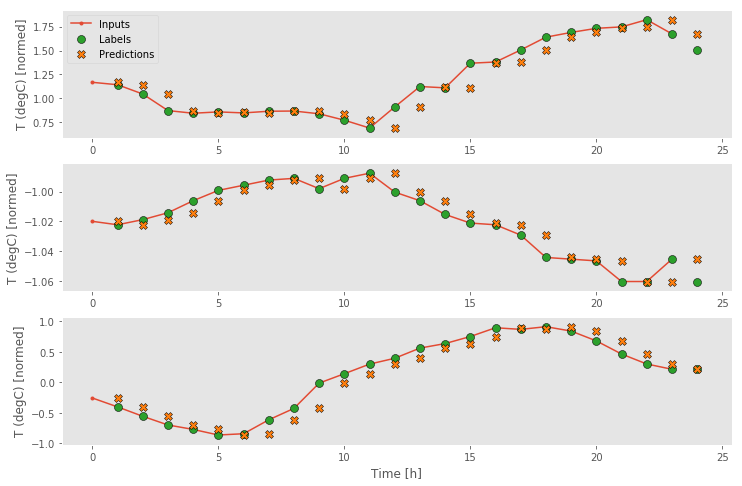

In [76]:
wide_window.plot(baseline)

    기준 모델의 예측값을 plot하면서, 1시간씩 오른쪽으로 이동한 단순 라벨임을 알 수 있음.